## Exploring Simulations of Galaxies and their Surrounding Gas

Stars form in the disks of galaxies but the gas that fuels star formation and that is ejected by the subsequent stellar explosions controls the rate of star formation. This gas is all found in the _circumgalactic medium_ - the region beyond the galactic disk but within the gravitational influence of the galaxy.

In this notebook, we look at a 3D, hydrodynamics simulation of a galaxy like the Milky Way. In particular, this simulation contains high resolution in the _outer_ part of the galaxy, where the pixel size is typically large. We can use this resolution to examine the processes driving galaxy evolution. 

### Holoviews + Datashader for Interactive Plotting of Large Data

In particular, this notebook uses holoviews and datashader to create interactive plots that really allow you to interact with the simulated data. Google the packages to learn more! If the toggle buttons aren't visible, stretch the window of your browser wider.


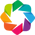

In [1]:
import numpy as np
import holoviews as hv
hv.extension('bokeh', 'matplotlib')
import xarray as xr
import matplotlib.cm as cm
from holoviews import streams
from holoviews.streams import Stream
import cPickle
from radial_data_nozeros import *
from holoviews.operation.datashader import aggregate, datashade, dynspread, shade


In [2]:
## First let's load in the data! and see what's inside

data_3D = xr.open_dataset('sim_data.h5') #data saved as xarray
data_3D = hv.Dataset(data_3D) #let the data function within the holoviews plotting framework
data_3D

:Dataset   [y,x,z]   (metallicity,temperature,density)

So this data is a cubic volume with metallicity, temperature, and density given at every point.

As you plot this Dataset, holoviews remembers the information for all of the potential variables making it easy to see relation between all of the dependent quantities.

### Physical Properties of the Galaxy

Simulations allow us to know the exact physical quantities of the galaxy at any point throughout the box. We can use this ?? to 

In [3]:
%opts Image [width=225 height=625 colorbar=True colorbar_position='bottom'] 

## Holoviews uses magic keywords to set plot properties.

#Create an Image of the vdims quantity for the kdims dimensions and let me scroll through the groupby dimension 
tempplt   = data_3D.to(hv.Image,vdims=['temperature'],groupby='z',
                          label='Temperature [log(K)]',dynamic=True,kdims=['x','y'])
densplt  = data_3D.to(hv.Image,vdims=['density'],groupby='z',label='Density [log(g/cm^3)]',dynamic=True,kdims=['x','y'])
metalplt = data_3D.to(hv.Image,vdims=['metallicity'],groupby='z',label='Metallicity [Z_sun]',dynamic=True,kdims=['x','y'])

#These keywords control the color maps and make sure the colorbar range stays stable, letting color differences
#correpond to actual differences in the data
densplt = densplt.opts(style=dict(cmap=cm.viridis)).redim.range(density=(-30, -23))
tempplt = tempplt.opts(style=dict(cmap=cm.Reds)).redim.range(temperature=(3, 7))
metalplt = metalplt.opts(style=dict(cmap=cm.rainbow)).redim.range(metallicity=(-3, 1))

#combine each plot to display simultaneously!
(densplt + tempplt + metalplt).redim.label(x='x [kpc]',y='y [kpc]')



:Layout
   .DynamicMap.I   :DynamicMap   [z]
   .DynamicMap.II  :DynamicMap   [z]
   .DynamicMap.III :DynamicMap   [z]

In the center of these plots, the disk is clearly identifiable as dense, cool, and metal-enriched. Scrolling through the z-axis, we can how the outflows are driven from the galaxy. The resolution demonstrates that mixing proceeds on small scales and enables a wide range of densities, temperatures, and metallicites to exist throughout the circumgalactic medium. 

In [4]:
## Exercise: Try changing which axis to scroll through the simulated data and adjust 
## the size of the plots to match the changing size of the axes!

### Observable Properties of the Galaxy

While we can take advantage of knowing all of the physical information, observations are limited to quantities measured with a telescope. For this diffuse gas throughout the outer parts of the galaxy, all we can measure is the total amount of gas in a particular ion state - say carbon that's been triplely ionized (CIV). We call this quantity the _column density_. 

We compute what the column density in a series of ions would be for our simulated galaxy. Let's map what the values are at all pixels and then show them as a function of distance.

In [5]:
## Here's some functions we're going to need to look at the column densities as a 
## function of distance from the center of the galaxy.

def sym_coldens_profile(frb):
    whole_box = np.zeros((200,200))
    dx = 40 #20/0.5
    dy = 100 #50/0.5

    #frb = frb.T
    whole_box[:,100-dx:100+dx] = frb #np.log10(frb)
    mask = np.zeros((200,200),dtype=bool)
    mask[:,100-dx:100+dx] = True

    xL = np.linspace(-50,50,200)
    xL,yL = np.meshgrid(xL,xL)
    rp = radial_data(whole_box,working_mask=mask,x=xL,y=yL)
    return rp,xL,whole_box,mask

def create_datashade_frb(whole_box,r,mask):
    frb_out = whole_box[mask].ravel()
    r_out = r[mask].ravel()
    frb_coldens = np.zeros((len(r_out),2))
    frb_coldens[:,0] = r_out
    frb_coldens[:,1] = frb_out
    return frb_coldens

In [10]:
#%%output size=150 filename='phase_test' fig='png'

## These are the ions we're going to plot.
ions = ['HI','CIV','OVI']

#this uses the x and y positions to generate a radius to the center oft the galaxy.
xL = np.linspace(-50,50,200)
xL,yL = np.meshgrid(xL,xL)
r = abs(xL+1j*yL)

matrix = {}

for ion in ions:
    #load the data
    frb = cPickle.load(open(ion+'.cpkl','rb'))
    frb = np.log10(frb)
    
    # Plot a map of the column density values
    image1 = hv.Image(frb)
    image1 = image1.opts(style=dict(cmap=cm.plasma),plot=dict(width=250,height=500,colorbar=True,
                                                             colorbar_position='bottom'))
    
    #calculate the median column density as a function of radius
    rp,xL,whole_box,mask = sym_coldens_profile(frb)
        
    frb_coldens = create_datashade_frb(whole_box,r,mask)
    ylabel = ion+' Coldens [cm^-2]'
        
    ##Plot the column density values
    points1 = hv.Points(frb_coldens,kdims=['Impact Parameter [kpc]',ylabel])
    
    #Plot the median profile
    rp_curve = hv.Curve((rp.r,rp.median))
        #image1 = hv.Image(frb,ylabel).opts(style=dict(cmap=cm.plasma))
    
    #combine the points and curves on the same plot
    final_plot = (datashade(points1,cmap=cm.gray,dynamic=False,
                            x_range=(0,55),y_range=(5,25)
                            )* rp_curve(style=dict(line_width=3,line_color='#e7298a')))
    
    #add in the column density map
    final_plot = image1 + final_plot
    matrix.update({(ion):final_plot})
        
opts = {'GridSpace': {'plot': dict(xaxis='bottom', shared_xaxis=False, shared_yaxis=False,
                                    yaxis='left', bgcolor='white')}}



In [11]:
coldens_plots = hv.HoloMap(matrix,kdims=['ion']).collate() ## set up matrix visualization
coldens_plots

:Layout
   .Image.I   :HoloMap   [ion]
      :Image   [x,y]   (z)
   .Overlay.I :HoloMap   [ion]
      :Overlay
         .RGB.I   :RGB   [Impact Parameter [kpc],OVI Coldens [cm^-2]]   (R,G,B,A)
         .Curve.I :Curve   [x]   (y)

The presence of an ion is determined by the density and temperature of the gas and it's strength is dependent on the metallicity - the amount of a metal in the gas relative to hydrogen. 

Neutral hydrogen - HI - is found in cold, dense gas. <br/>
C missing three electrons - CIV - is found in warm (T ~ 10^5 K) gas. <br/>
O missing five electrons - OVI - probes hot gas (T ~ 10^6 K) gas. 


The slices of density, temperature, and metallicity can clearly be traced in the projections of these ions. Hydrogen is the most abundant element so the total amount of HI is highest. Dense structures are more visible in HI than in OVI. Most of the gas is hot, so OVI is strong throughout the galaxy unlike the other ions.

Scientists use these ions to probe the state of the gas that drives galaxy formation.